In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests

In [2]:
import os
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filename = "input.txt"

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"{filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        # Optional: Clean up partially downloaded file if error occurred
        if os.path.exists(filename):
            os.remove(filename)
else:
    print(f"{filename} already exists. Skipping download.")

input.txt downloaded successfully.


In [47]:
#Hyperparameters
batch_size = 64 #Number of token chunks per batch #UPDATED
context_length = 256 #Length of the token chunks. Andrej called this block size #UPDATED
embedding_dim = 384 #The vector size of the token embeddings. Andrej used n_embed as the variable name. #UPDATED
head_size1 = 16 #Self attention head size
num_layers = 6 #Number of transformer block layers # NEW
num_heads = 6  # NEW
learning_rate = 3e-4 #UPDATED
dropout = 0.2 #NEW
max_iters = 5000 #Number of training iterations or steps.
eval_interval = 500 #Number of steps between evaluating the validation set to see how our validation loss is doing. #UPDATED
eval_iters = 200 #Number of steps to do on the validation set per each interval. We do more than 1 to get a more accurate overall valid loss
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Instead of using the cpu, we'll use the GPU if it's availble.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

#Dataset
with open('input.txt','r',encoding='utf-8') as f:
    text = f.read()
vocab = sorted(list(set(text))) #Called chars in the video, but vocab is a more generic term. Both are correct.
vocab_size = len(vocab)

char2idx = {char:idx for idx,char in enumerate(vocab)}
idx2char = {idx:char for char,idx in char2idx.items()}
encode = lambda x: [char2idx[char] for char in x]
decode = lambda idxs: ''.join([idx2char[idx] for idx in idxs])

tokenized_text = torch.tensor(encode(text),dtype=torch.long)

#Train / Valid split.
train_test_split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:train_test_split_idx]
valid_data = tokenized_text[train_test_split_idx:]

In [48]:
def plot_losses(losses):
    train_losses = [o['train'] for o in losses if o.get('train') is not None]
    valid_losses = [o['valid'] for o in losses if o.get('valid') is not None]
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

In [49]:
def get_batch(split:str, batch_size:int=batch_size, context_length:int=context_length):
    #Function to get a batch of data from the train or valid dataset
    data = train_data if split == 'train' else valid_data
    idxs = torch.randint(low=0, high=len(data)-context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx+context_length] for idx in idxs])
    y = torch.stack([data[idx+1:idx+context_length+1] for idx in idxs])
    x,y = x.to(device), y.to(device) #Send data to the GPU if available
    return x,y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train','valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [50]:
class FeedForwardNetwork(nn.Module):
    """A simple linear network followed by a non-linearity"""
    def __init__(self, embedding_dim:int=embedding_dim, dropout:float=dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim*4),
            nn.ReLU(),
            nn.Linear(in_features=self.embedding_dim*4, out_features=self.embedding_dim),
            nn.Dropout(dropout), #NEW
        )
    def forward(self, x):
        return self.ffn(x)

In [51]:
class Head(nn.Module):
    """ one head of self attention """
    def __init__(self, head_size:int, embedding_dim:int=embedding_dim,
                 context_length:int=context_length, dropout:float=dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer   = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((self.context_length, self.context_length))))
        self.dropout_layer = nn.Dropout(dropout) # NEW

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        assert T <= self.context_length
        assert C == self.embedding_dim
        q = self.query_layer(x) #(B,T,C) (batch size, context length, head_size)
        k = self.key_layer(x) #(B,T,C) (batch size, context length, head_size)
        v = self.value_layer(x) #(B,T,C) (batch size, context length, head_size)

        #compute scores based on affinities
        weights = (q @ k.transpose(-2,-1)) * self.head_size**-0.5 # (B,T,C) @ (B,C,T) -> (B,T,T) #FIXED ^-.5 is 1/sqrt() so need to mult, not div
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) #(B,T,T)
        weights = F.softmax(input=weights, dim=-1) #(B,T,T)
        weights = self.dropout_layer(weights) # NEW

        #perform weighted aggragation of the values
        out = weights @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out

# Head()(x)

In [52]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads:int, head_size:int, embedding_dim:int=embedding_dim,
                 context_length:int=context_length, dropout:float=dropout):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([
            Head(head_size=self.head_size, embedding_dim=self.embedding_dim,
                 context_length=self.context_length)
            for _ in range(self.num_heads)])

        self.projection_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim, bias=True)
        self.dropout_layer = nn.Dropout(dropout) # NEW

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out) # NEW
        return out

In [53]:
class TransformerBlock(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self, num_heads:int, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 dropout:float=dropout): #UPDATED
        #embedding_dim: embedding dimension, num_heads: the number of heads that we want
        super().__init__()
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = embedding_dim // num_heads
        self.num_heads = num_heads
        self.dropout = dropout # NEW

        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=num_heads, head_size=self.head_size,
                                                                   embedding_dim=embedding_dim, context_length=context_length,
                                                                   dropout=dropout) #UPDATED
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim, dropout=dropout)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.embedding_dim)

    def forward(self, x):
        x = x + self.multi_self_attention_heads_layer(self.layer_norm_1(x))
        x = x + self.feed_forward_network(self.layer_norm_2(x))
        return x


Step: 0 Training Loss: 4.285 Validation Loss: 4.282
Step: 200 Training Loss: 2.392 Validation Loss: 2.415
Step: 400 Training Loss: 2.012 Validation Loss: 2.09
Step: 600 Training Loss: 1.773 Validation Loss: 1.912
Step: 800 Training Loss: 1.632 Validation Loss: 1.809
Step: 1000 Training Loss: 1.535 Validation Loss: 1.725
Step: 1200 Training Loss: 1.465 Validation Loss: 1.667
Step: 1400 Training Loss: 1.413 Validation Loss: 1.617
Step: 1600 Training Loss: 1.37 Validation Loss: 1.594
Step: 1800 Training Loss: 1.336 Validation Loss: 1.567
Step: 2000 Training Loss: 1.31 Validation Loss: 1.552
Step: 2200 Training Loss: 1.283 Validation Loss: 1.525
Step: 2400 Training Loss: 1.261 Validation Loss: 1.514
Step: 2600 Training Loss: 1.238 Validation Loss: 1.51
Step: 2800 Training Loss: 1.227 Validation Loss: 1.509
Step: 3000 Training Loss: 1.204 Validation Loss: 1.492
Step: 3200 Training Loss: 1.186 Validation Loss: 1.489
Step: 3400 Training Loss: 1.169 Validation Loss: 1.486
Step: 3600 Training L

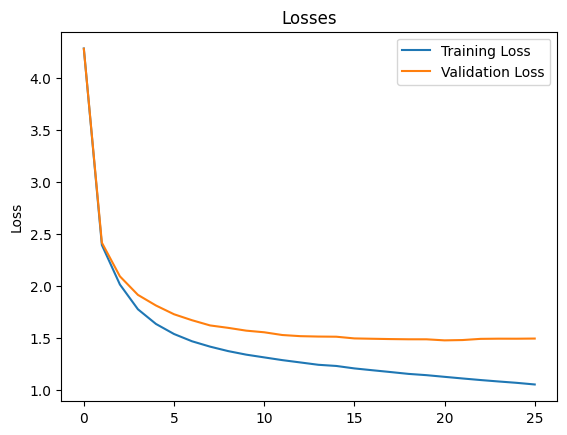


But with prison: I will steel with my fame?
For myself I'll reconceive without 'larganes' form,
Provoke itself a lewful manifies.
Affright the feelow me slaves of these weep,
Or most lords, lets her rebals to do me here
Tewlate the sun of Margary can see hence without
With not thine twenty, cousin, their bearing their
stephes; I am likers again.

ISABELLA:
As I was recelless lack to such, my lord,
I pray now. Dorset, leave it with pains in thine!
For Even bring you! and you writes must me go:
no
CPU times: user 1h 3min 10s, sys: 5min 28s, total: 1h 8min 38s
Wall time: 1h 8min 56s


In [54]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, head_size:int, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 num_layers:int=num_layers, dropout:float=dropout, num_heads:int=num_heads): #UPDATED
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size
        self.num_layers = num_layers #NEW
        self.dropout = dropout

        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        self.transformer_blocks = nn.Sequential(*([
            TransformerBlock(embedding_dim=embedding_dim, num_heads=num_heads, context_length=context_length,
                             dropout=self.dropout) for _ in range(self.num_layers)]+[
            nn.LayerNorm(embedding_dim)
        ])) #UPDATED
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.transformer_blocks(x)
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(head_size=head_size1, vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',round(losses['train'].item(),3),'Validation Loss:',round(losses['valid'].item(),3))

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

In [70]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Create the directory if it doesn't exist
save_dir = "/content/gdrive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)

# Now save the model to a file within that directory
model_path = os.path.join(save_dir, "shakespeare_model.pt")  # Give your model a specific filename
torch.save({
    'epoch': 5000,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, model_path)

print(f"Model saved to {model_path}")

Mounted at /content/gdrive
Model saved to /content/gdrive/MyDrive/Models/shakespeare_model.pt


In [73]:
# Load the saved model checkpoint
checkpoint_path = "/content/gdrive/MyDrive/Models/shakespeare_model.pt"
checkpoint = torch.load(checkpoint_path)

# If you need to recreate your model first (assuming same architecture as before)
# This depends on your model definition - this is a placeholder example
model = TransformerLanguageModel(
    head_size = head_size1,
    vocab_size = vocab_size,
    embedding_dim=embedding_dim,
    context_length=context_length,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout
).to(device)

# Load the saved state dictionary into your model
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# Function to estimate loss on validation data
@torch.no_grad()  # Disable gradient calculation for evaluation
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Run evaluation
losses = estimate_loss()
print(f"Validation Loss: {losses['val']:.4f}")
print(f"Training Loss: {losses['train']:.4f}")


Validation Loss: 1.4919
Training Loss: 1.0462
Final training loss from saved checkpoint: 1.1550
